In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, cycler
cmap = mpl.cm.get_cmap('inferno')

from fiber_properties import (frd, image_list, FiberImage, save_plot,
                              plot_frd_encircled_energy,
                              plot_frd_encircled_energy_comparison,
                              plot_frd_input_output,
                              plot_frd_energy_loss)

colors = ['black', 'red', 'orange', 'yellow', 'gray', 'pink']

rc('figure', figsize=[3.39, 3.0])
rc('text', usetex=True)
rc('text.latex', preamble= [r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
                            r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#                             r'\usepackage{helvet}',    # set the normal font here
#                             r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
#                             r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
                            ])

rc('font', size=10, family='serif', serif=['Computer Modern Roman'])
rc('axes', labelsize=10, linewidth=1, unicode_minus=True,
   prop_cycle=cycler('color', colors))
rc('legend', frameon=False, fontsize=10, labelspacing=0.5, numpoints=1)
rc('lines', linewidth=1)

rc('xtick', labelsize=10, direction='in', top=True)
rc('xtick.major', size=4, width=1)
rc('xtick.minor', visible=True, size=2, width=1)

rc('ytick', labelsize=10, direction='in', right=True)
rc('ytick.major', size=4, width=1)
rc('ytick.minor', visible=True, size=2, width=1)

print('Complete')


Complete


In [3]:
NEW_OBJECTS = False
THRESHOLD = 2000
FOLDER = '../data/frd/'

def image_list_frd(image_name, f_ratios, **kwargs):
    return [image_list(image_name+str(f)+'/im_', **kwargs) for f in f_ratios]

def ambient_files(folder):
    return image_list(folder+'ambient/ff_')

def input_files(folder, f):
    return image_list(folder+'input_'+str(f)+'/ff_')

def output_files(f):
    return image_list(FOLDER+'/output_'+str(f)+'/ff_')

def input_objects(folder, in_f):
    for f in in_f:
        if NEW_OBJECTS or 'ff_obj.pkl' not in os.listdir(folder+'input_'+str(f)):
#             print('Saving ' + folder + 'input_' + str(f))
            im_obj = FiberImage(input_files(folder, f),
                                ambient=ambient_files(folder),
                                input_fnum=f,
                                threshold=THRESHOLD,
                                camera='ff')
            im_obj.save_object(folder+'input_'+str(f)+'/ff_obj.pkl')
    return [folder+'input_'+str(f)+'/ff_obj.pkl' for f in in_f]

def output_objects(out_f):
    for f in out_f:
        if NEW_OBJECTS or 'ff_obj.pkl' not in os.listdir(FOLDER+'output_'+str(f)):
#             print('Saving output_' + str(f))
            im_obj = FiberImage(output_files(f),
                                output_fnum=f,
                                threshold=THRESHOLD,
                                camera='ff')
            im_obj.save_object(FOLDER+'output_'+str(f)+'/ff_obj.pkl')
    return [FOLDER+'output_'+str(f)+'/ff_obj.pkl' for f in out_f]
        
class Container(object):
    def __init__(self, name, folder, in_f, out_f):
        self.name = name
        self.folder = folder
        self.in_objs = input_objects(folder, in_f)
        self.out_objs = output_objects(out_f)
        self.output = None
        
print('Complete')
        

Complete


In [4]:
NEW_DATA = False
TITLE = 'Modal Noise'
TESTS = [Container('unagitated', FOLDER+'unagitated/', [3.0, 4.0, 5.0], [3.0, 4.0, 5.0]),
         Container('agitated', FOLDER+'agitated/', [3.0, 4.0, 5.0], [3.0, 4.0, 5.0])]
for test in TESTS:
    print('Calculating FRD for '+ test.name + ' fiber')
    test.output = frd(test.in_objs, test.out_objs,
                      cal_method='full', save_objs=True,
                      new=NEW_DATA)
    

frd_outputs = [test.output for test in TESTS]
labels = [test.name for test in TESTS]

print('Complete')


Calculating FRD for unagitated fiber
Calculating FRD for agitated fiber
Complete


Complete


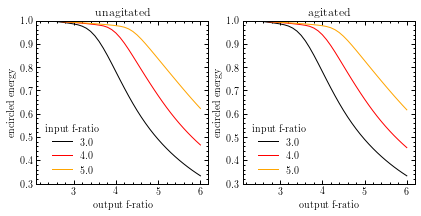

In [5]:
fig, axes = plt.subplots(1, len(TESTS), figsize=[6.78, 3.0])

for test, ax in zip(TESTS, axes):
    frd_info = test.output[0]
    
    for i in range(len(frd_info.input_fnum)):
        ax.plot(frd_info.encircled_energy_fnum[i],
                frd_info.encircled_energy[i],
                label=str(frd_info.input_fnum[i]))
        ax.set_xlabel('output f-ratio')
        ax.set_ylabel('encircled energy')
        ax.set_ylim(ymax=1)
        ax.legend(loc='best', title='input f-ratio')
        ax.set_title(test.name)
    
#     plot_frd_encircled_energy(test.output)
#     save_plot(test.folder + test.name + ' FRD.png')

print('Complete')


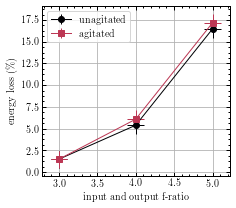

In [6]:
fig, ax = plt.subplots(figsize=[3.39, 3.0])

markers = ['o', 's', '^', 'X', 'P']
colors = [cmap(i) for i in np.linspace(0.0, 0.5, 2)]

for output, label, marker, color in zip(frd_outputs, labels, markers, colors):
    frd_info = output[0]
    magn = output[1]
    magn_list = output[2]
    magn_error = output[3]
    
    xerr = [np.sqrt(0.1**2 + (magn_error*f)**2) for f in frd_info.input_fnum]
    yerr = 1

    ax.errorbar(frd_info.input_fnum,
                frd_info.energy_loss,
                xerr=xerr,
                yerr=yerr,
                label=label,
                marker=marker,
                color=color)

ax.set_xlabel('input and output f-ratio')
ax.set_ylabel('energy loss (\%)')
ax.grid()
ax.legend(frameon=True, loc=2)

fig.tight_layout()
fig.savefig('frd_energy_loss.pdf')


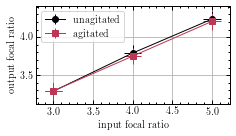

In [7]:
fig, ax = plt.subplots(figsize=[3.39, 2.0])

colors = [cmap(0), cmap(0.5)]
markers = ['o', 's']

for output, label, marker, color in zip(frd_outputs, labels, markers, colors):
    frd_info = output[0]
    magn_error = output[3]
    xerr = [np.sqrt(0.1**2 + (magn_error*f)**2) for f in frd_info.input_fnum]
    yerr = [np.sqrt(0.1**2 + (magn_error*f)**2) for f in frd_info.output_fnum]

    ax.errorbar(frd_info.input_fnum,
                frd_info.output_fnum,
                xerr=xerr,
                yerr=yerr,
                label=label, marker=marker, color=color)
    
ax.set_xlabel('input focal ratio')
ax.set_ylabel('output focal ratio')
ax.legend(frameon=True)
ax.grid()

fig.tight_layout()
fig.savefig('frd_input_output.pdf')


In [8]:
for output, label in zip(frd_outputs, labels):
    print(label)
    inp = output[0].input_fnum
    out = output[0].output_fnum
    err = np.sqrt(output[3]**2 + 0.1**2)
    for i in range(3):
        print(r'{}: {} +/- {}'.format(round(inp[i], 1), round(out[i], 1), round(err, 1)))

unagitated
3.0: 3.3 +/- 0.1
4.0: 3.8 +/- 0.1
5.0: 4.2 +/- 0.1
agitated
3.0: 3.3 +/- 0.1
4.0: 3.8 +/- 0.1
5.0: 4.2 +/- 0.1
